## Install MMSegmentation

In [ ]:
!pip install -U openmim
!mim install mmengine
!mim install "mmcv>=2.0.0"
!pip install ftfy
!pip install torch==2.0.0 torchvision==0.15.1 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu118

In [ ]:
!git clone -b main https://github.com/open-mmlab/mmsegmentation.git
!cd mmsegmentation
!pip install -v -e .

# Set up environment and download dataset

In [2]:
# Select local or Google Colab environment (Uncomment used environment)

# ---------------------------------------------------------------------------
env = ["local", "colab"][0]
print(f"Selected Environment: {env}")

# ---------------------------------------------------------------------------
if env == "colab":
    from google.colab import drive
    drive.mount('/content/drive')
    data_dir = "/content/drive/MyDrive/OR/P2/_data/"
    root = data_dir + "fashionpedia/"
    annot_dir = root + "Annotations/"

    # # Download and untar dataset (First time only)
    # !wget https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip
    # !unzip train2020.zip -d $root
    # !wget https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
    # !unzip val_test2020.zip -d $root
    # !wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json -P $annot_dir
    # !wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json -P $annot_dir
    # !wget https://s3.amazonaws.com/ifashionist-dataset/annotations/info_test2020.json -P $root

elif env == "local":
    data_dir = "../_data/"
    root = data_dir + "fashionpedia/"
    annot_dir = root + "Annotations/"

    # # Download and untar dataset (First time only)
    # !wget https://s3.amazonaws.com/ifashionist-dataset/images/train2020.zip
    # !unzip train2020.zip -d $root
    # !wget https://s3.amazonaws.com/ifashionist-dataset/images/val_test2020.zip
    # !unzip val_test2020.zip -d $root
    # !wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_train2020.json -P $annot_dir
    # !wget https://s3.amazonaws.com/ifashionist-dataset/annotations/instances_attributes_val2020.json -P $annot_dir
    # !wget https://s3.amazonaws.com/ifashionist-dataset/annotations/info_test2020.json -P $root

# ---------------------------------------------------------------------------
# Set models and figures directories
models_dir = data_dir + '_models/'
figures_dir = data_dir + '_figures/'
config_dir = "../mmsegmentation/configs"
# ---------------------------------------------------------------------------

Selected Environment: local


# Load and prepare data for training

In [3]:
from glob import glob
import cv2
import numpy as np
import xml.etree.ElementTree as ET
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme()
import pandas as pd
import os
import json
import mmseg
import mmcv
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from mmseg.apis import inference_model, init_model, show_result_pyplot
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF

import torch.nn.functional as F

# ================================================================================================

import platform
import sys

os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"

print(f"Python Platform: {platform.platform()}")
print(f"Python {sys.version}\n")
print(f"OpenCV {cv2.__version__}")
print(f"Numpy {np.__version__}")
print(f"Matplotlib {matplotlib.__version__}")
print(f"Seaborn {sns.__version__}")
print(f"Pandas {pd.__version__}")
print(f"Torch {torch.__version__}")
print(f"MMCV {mmcv.__version__}")
print(f"MMSEG {mmseg.__version__}")

Python Platform: Windows-10-10.0.22631-SP0
Python 3.8.19 (default, Mar 20 2024, 19:55:45) [MSC v.1916 64 bit (AMD64)]

OpenCV 4.9.0
Numpy 1.24.3
Matplotlib 3.7.5
Seaborn 0.13.2
Pandas 2.0.3
Torch 2.0.0
MMCV 2.1.0
MMSEG 1.2.2


In [4]:
def load_annotations(annotation_file):
    with open(annotation_file) as f:
        data = json.load(f)
        
    images = pd.DataFrame(data['images'])
    annotations = pd.DataFrame(data['annotations'])
    categories = pd.DataFrame(data['categories'])
    
    return images, annotations, categories

def aggregate_rellevant_training_data(group):
    category_ids = []
    segmentations = []
    file_name = ""
    
    for _, row in group.iterrows():
        category_ids.append(row['category_id'])
        segmentation = row['segmentation']
        if isinstance(segmentation, list):  # If polygon encoded
            segmentations.extend(segmentation)
        elif isinstance(segmentation, dict):  # If RLE encoded
            segmentations.append(segmentation)
        file_name = row['file_name']

    result_df = pd.Series({'image_id': group['image_id'].iloc[0], 'categories_ids': category_ids, 'segmentations': segmentations, 'file_name': file_name})
    return result_df

In [5]:
train_images, train_annotations, train_categories = load_annotations(annot_dir + "/instances_attributes_train2020.json")

train_merged_df = pd.merge(train_annotations, train_images, left_on='image_id', right_on='id', how='outer')
train_merged_df = train_merged_df.drop(columns=['id_x', 'id_y', 'license', 'time_captured', 'isstatic', 'original_url', 'iscrowd', 'kaggle_id'])

train_data = train_merged_df.groupby('image_id').apply(aggregate_rellevant_training_data)
train_data.reset_index(drop=True, inplace=True)

val_images, val_annotations, val_categories = load_annotations(annot_dir + "/instances_attributes_val2020.json")

val_merged_df = pd.merge(val_annotations, val_images, left_on='image_id', right_on='id', how='outer')
val_merged_df = val_merged_df.drop(columns=['id_x', 'id_y', 'license', 'time_captured', 'isstatic', 'original_url', 'iscrowd', 'kaggle_id'])

val_data = val_merged_df.groupby('image_id').apply(aggregate_rellevant_training_data)
val_data.reset_index(drop=True, inplace=True)

val_data.head()

,image_id,categories_ids,segmentations,file_name
0,2083,"[29, 32, 32, 32, 31, 31, 34, 19, 13, 28, 4, 0,...","[[263, 255, 250, 268, 237, 278, 253, 290, 228,...",7fc8a54146a81b33f348f21ad07fa141.jpg
1,5593,"[31, 33, 24, 10, 31]","[[571, 352, 577, 407, 577, 418, 579, 441, 582,...",5f1a6fc913ba40dee4d94b3428afba15.jpg
2,6410,"[23, 23, 6, 4, 32, 32, 29, 32, 19, 31, 31, 34]","[[280, 911, 281, 924, 287, 929, 292, 929, 293,...",c201083bb1f8b26dba075f380aa799bc.jpg
3,7487,"[33, 1, 23, 23, 6]","[[302, 216, 304, 228, 310, 239, 318, 248, 326,...",d36482dcef46afcfcb7d96013c0715c2.jpg
4,7731,"[7, 1, 9, 31, 28, 23, 23, 32, 13, 32]","[[592, 377, 602, 385, 604, 387, 612, 389, 615,...",50ab7c8b2848817931e5879671e234ae.jpg


# Train model

In [6]:
classes = ['pocket', 'sleeve', 'sock', 'collar', 'shirt, blouse', 'dress', 'shoe',
           'tights, stockings', 'glasses', 'belt', 'bag, wallet', 'neckline',
           'pants', 'hood', 'epaulette', 'coat', 'top, t-shirt, sweatshirt',
           'zipper', 'hat', 'lapel', 'jacket', 'flower', 'ruffle', 'applique',
           'skirt', 'buckle', 'scarf', 'glove', 'shorts', 'jumpsuit', 'bead',
           'watch', 'tie', 'headband, head covering, hair accessory', 'umbrella',
           'fringe', 'rivet', 'sweater', 'cardigan', 'vest', 'sequin', 'ribbon',
           'bow', 'cape', 'tassel', 'leg warmer']
palette = [255, 251, 247, 243, 239, 235, 231, 227, 223, 219, 215, 211, 207, 203, 199, 195, 191, 187, 183, 179, 175, 171, 167, 163, 159, 155, 151, 147, 143, 139, 135, 131, 127, 123, 119, 115, 111, 107, 103, 99, 95, 91, 87, 83, 79, 75]

In [7]:
def preprocess_image(image_path):
    train_transforms = transforms.Compose([
        transforms.RandomRotation(degrees=20),  # Random rotation (±20 degrees)
        transforms.RandomHorizontalFlip(),      # Random horizontal flip
        transforms.RandomVerticalFlip(),        # Random vertical flip
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), 
        #transforms.RandomResizedCrop(size=(height, width), scale=(0.8, 1.0)),  # Random resized crop
        transforms.RandomAffine(degrees=0, translate=(0.1, 0.1), scale=(0.9, 1.1), shear=0.1),  # Random affine transformation
        transforms.ToTensor(),                  # Convert image to tensor
    ])
    
    img = mmcv.imread(image_path)
    img = train_transforms(img)
    return img

def inference_and_visualize(model, image_path, output_dir):
    img = preprocess_image(image_path)
    result = inference_model(model, img)
    show_result_pyplot(model, img, result, show=False, out_file=os.path.join(output_dir, 'result.jpg'))

def plot_raw_segmented_image(image_info, image_path, figsize=(15, 15)):
    image = cv2.imread(image_path)
    masked_image = image.copy()

    encoded_pixels = image_info["segmentations"]
    class_ids = image_info["categories_ids"]

    # Plot the original image
    fig, axs = plt.subplots(1, 2, figsize=figsize)
    axs[0].imshow(image)

    mask = np.zeros_like(image[:, :, 0])
    for pixels, class_id in zip(encoded_pixels, class_ids):
        # Create a mask for the current segment
        vertices = np.array(pixels).reshape((-1, 2)).astype(np.int32)
        cv2.fillPoly(mask, [vertices], 255 - class_id * 4)

    axs[1].imshow(image)
    axs[1].imshow(mask, alpha=0.8)

    plt.show()
    
    
def save_raw_segmented_image(image_info, image_path, output_dir):
    image = cv2.imread(image_path)
    masked_image = image.copy()

    encoded_pixels = image_info["segmentations"]
    class_ids = image_info["categories_ids"]

    mask = np.zeros_like(image[:, :, 0])
    for pixels, class_id in zip(encoded_pixels, class_ids):
        # Create a mask for the current segment
        vertices = np.array(pixels).reshape((-1, 2)).astype(np.int32)
        cv2.fillPoly(mask, [vertices], 255 - class_id * 4)

    # Apply the mask to the image
    masked_image[mask > 0] = [0, 255, 0]  # Set mask region to green (you can change color if needed)

    # Save the masked image
    filename = os.path.basename(image_path)
    output_path = os.path.join(output_dir, filename)
    cv2.imwrite(output_path, masked_image)

def decode_rle(rle, class_id, image):
    """
    Decode a run-length encoded mask.
    """
    try:
        mask = np.zeros_like(image[:, :, 0], dtype=np.uint8)
        counts = rle["counts"]
        counts = counts.encode('utf-8')  # Encoding the string to bytes for correct parsing
        counts = np.frombuffer(counts, dtype=np.uint8) - 48  # Convert ASCII codes to integer values
   
        starts = np.cumsum(counts[::2])
        
        min_length = min(len(starts), len(counts[1::2]))
        starts = starts[:min_length]
        ends = starts + counts[1::2]
        ends = ends[:min_length]
        
        for start, end in zip(starts, ends):
            mask[start:end] = 255 - class_id * 4
        return mask
    except Exception as e:
        print(f"Error decoding RLE: {str(e)}")
        raise e

def train(model, train_loader, criterion, optimizer, DEVICE, IMAGE_HEIGHT, IMAGE_WIDTH, num_classes, epoch):
    model.train()
    log_interval = 10
    running_loss = 0.0

    for batch_idx, sample_batched in enumerate(train_loader):
        inputs = sample_batched['image'].to(DEVICE)
        masks = {class_id: mask.to(DEVICE) for class_id, mask in sample_batched['masks'].items()}

        optimizer.zero_grad()

        outputs = model(inputs)
        outputs = F.interpolate(outputs, size=(IMAGE_HEIGHT, IMAGE_WIDTH), mode='bilinear', align_corners=False)

        target_masks = torch.stack([masks[class_id].squeeze(1) for class_id in range(num_classes)], dim=1)
        
        loss = criterion(outputs, target_masks)

        loss.backward()

        optimizer.step()

        running_loss += loss.item() * inputs.size(0)

        # Print training statistics
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(inputs), len(train_loader.dataset),
                100. * batch_idx / len(train_loader), loss.item()))
            
        # Release memory
        inputs = None
        masks = None
        outputs = None
        torch.cuda.empty_cache()
        
    average_loss = running_loss / len(train_loader.dataset)
    return average_loss

def validate(model, val_loader, criterion, device):
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    
    with torch.no_grad():
        for inputs, targets in val_loader:
            #inputs, targets = inputs.to(device), targets.to(device)
            
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            val_loss += loss.item() * inputs.size(0)
            
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()
    
    accuracy = correct / total
    return val_loss / len(val_loader.dataset), accuracy

In [8]:
class FashionpediaDataset(torch.utils.data.Dataset):
    
    def __init__(self, data_df, root_dir, transform=None):
        self.data_df = data_df
        self.root_dir = root_dir
        self.transform = transform
        self.CLASSES = classes
        self.PALETTE = palette

    def __len__(self):
        return len(self.data_df)

    def __getitem__(self, idx):
        try:
            image_info = self.data_df.iloc[idx]
            image_path = os.path.join(self.root_dir, image_info['file_name'])
            image = cv2.imread(image_path)
            encoded_segments = image_info["segmentations"]
            class_ids = image_info["categories_ids"]
            masks = {class_id: np.zeros_like(image[:, :, 0], dtype=np.uint8) for class_id in range(len(self.CLASSES))}

            for segment, class_id in zip(encoded_segments, class_ids):
                if isinstance(segment, dict):  # If RLE encoded
                    segment_rle = decode_rle(segment, class_id,  image)
                    masks[class_id] = segment_rle

                else:  # If polygon encoded
                    segment_pol = np.array(segment).reshape((-1, 2)).astype(np.int32)
                    cv2.fillPoly(masks[class_id], [segment_pol], 255 - class_id * 4)

            sample = {'image': image, 'masks': masks}

            if self.transform:
                sample = self.transform(sample)

            return sample
        except Exception as e:
            if isinstance(segment, dict):
                print("Segment:", segment_rle.shape)
            else:
                print("Segment:", segment_pol.shape)
            print(f"Error processing item {idx}: {str(e)}")
            raise Exception
    
class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, masks = sample['image'], sample['masks']

        # Swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        masks = {class_id: mask.transpose((0, 1)) for class_id, mask in masks.items()}

        return {'image': torch.from_numpy(image), 'masks': masks}

class ApplyTransform(object):
    def __init__(self, transform):
        self.transform = transform

    def __call__(self, sample):
        image, masks = sample['image'], sample['masks']

        # Apply transformation to both image and masks
        image = self.transform(image)
        masks = {class_id: self.transform(mask) for class_id, mask in masks.items()}

        return {'image': image, 'masks': masks}

In [9]:
train_images_path = root + "/train"
val_images_path = root + "/test"
batch_size = 8
num_epochs = 2
IMAGE_HEIGHT = 192
IMAGE_WIDTH = 192
num_classes = 46

# Define transformations
train_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomRotation(degrees=20),
    transforms.RandomResizedCrop(size=(IMAGE_HEIGHT, IMAGE_WIDTH)),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.1),
    transforms.ToTensor(),
])

train_dataset = FashionpediaDataset(data_df=train_data,
                              root_dir=train_images_path,
                              transform=ApplyTransform(train_transforms))

val_dataset = FashionpediaDataset(data_df=val_data,
                              root_dir=val_images_path,
                              transform=ApplyTransform(train_transforms))

In [10]:
batch_size = 8
num_epochs = 2
log_interval = 10
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {DEVICE}")
config_file ='../ocrnet_hr18_4xb2-160k_cityscapes-512x1024.py'
train_loss = []
train_accuracy = []	
validation_loss = []
validation_accuracy = []

model = init_model(config_file, device=DEVICE)
model = model.to(DEVICE)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())

# Define data loaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

Using device: cuda


c:\users\laia\onedrive - universitat politècnica de catalunya\2nd semester\or\p2\or-p2\mmsegmentation\mmseg\models\losses\cross_entropy_loss.py:250: UserWarning: Default ``avg_non_ignore`` is False, if you would like to ignore the certain label and average loss over non-ignore labels, which is the same with PyTorch official cross_entropy, set ``avg_non_ignore=True``.
  warnings.warn(


In [11]:
# Training loop
for epoch in range(num_epochs):
    t_loss = train(model, train_loader, criterion, optimizer, DEVICE, IMAGE_HEIGHT, IMAGE_WIDTH, num_classes, epoch)
    train_loss.append(t_loss)
    # train_accuracy.append(t_acc)
    val_loss, val_accuracy = validate(model, val_loader, criterion, DEVICE)
    validation_loss.append(val_loss)
    validation_accuracy.append(val_accuracy)
            
    # # Release memory
    # inputs = None
    # masks = None
    # outputs = None
    # torch.cuda.empty_cache()


Train Epoch: 0 [0/45623 (0%)]	Loss: 1.098474
Train Epoch: 0 [80/45623 (0%)]	Loss: 1.290665
Train Epoch: 0 [160/45623 (0%)]	Loss: 0.599257


# Test results

Testing the results obtained on a trained model

In [30]:
visualization_output_directory = "visualization_results"
os.makedirs(visualization_output_directory, exist_ok=True) 

test_images_path = root + "/test"
for index, row in test_images.iterrows():
    image_path = os.path.join(test_images_path, row["file_name"])
    inference_and_visualize(model, image_path, visualization_output_directory)

TypeError: Unexpected type <class 'numpy.ndarray'>

# Plot some sample images

Image ID: 14802
Image path: fashionpedia\train\3c6d350f5a5dbb8f838445779d6d7649.jpg
Image info: image_id                                                      17835
categories_ids                                 [10, 24, 23, 23, 33]
segmentations     [[223, 348, 219, 364, 214, 389, 210, 415, 211,...
file_name                      3c6d350f5a5dbb8f838445779d6d7649.jpg
Name: 14802, dtype: object


ValueError: cannot reshape array of size 1 into shape (2)

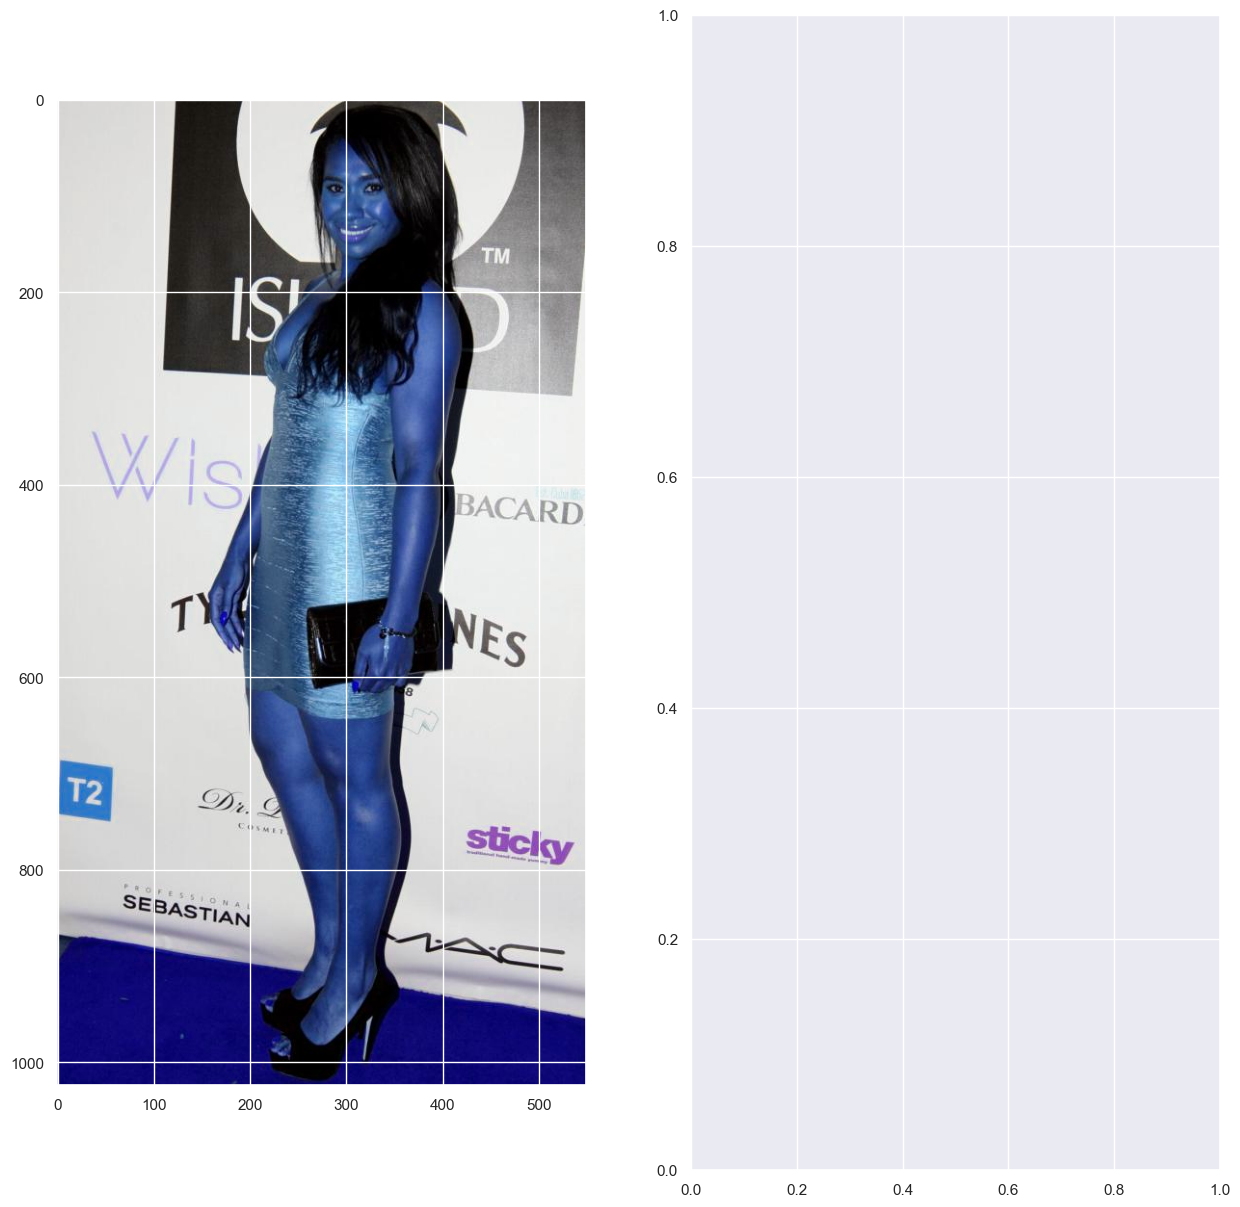

In [20]:
samples = 1
train_images_path = os.path.join(root, "train")

for _ in range(samples):
    random_id = relevant_training_data.sample().index[0]
    print("Image ID:", random_id)
    image_path = os.path.join(train_images_path, relevant_training_data.iloc[random_id]["file_name"])
    print("Image path:", image_path)
    image_info = relevant_training_data.iloc[random_id]
    print("Image info:", image_info)

    plot_raw_segmented_image(image_info, image_path)